In [1]:
# import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Flatten
import tensorflow_model_optimization as tfmot
import keras
from keras.utils import plot_model
import pydot, graphviz
from random import random

In [2]:
#df = pd.read_csv('../ml/dataset_management/refit/kettle/kettle_training_.csv').to_dict()
#df['aggregate'] = {key: df['aggregate'][key] for key in range(10)}
#df['kettle'] = {key: df['kettle'][key] for key in range(10)}

In [3]:
# configuration
num_features = 5
window_length = 20
batch_size = num_features * 200 # https://stackoverflow.com/questions/61029052/what-is-the-batchsize-in-tensorflows-model-fit-function
model = Sequential()
rnd = 0.1
epochs = 500
test_batch_size  = 2000

In [5]:
# input layer
model.add(Input(shape=(window_length)))
model.add(tf.keras.layers.Reshape(target_shape=(window_length, 1)))
# conv1 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# conv2 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# conv3 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# gap
model.add(tf.keras.layers.GlobalAveragePooling1D())
# output layer
model.add(tf.keras.layers.Dense(num_features, activation="softmax"))

In [6]:
# TensorBoard 2.15.1 at http://localhost:6006/
#keras.callbacks.TensorBoard(
#    log_dir="/Users/Olaf/Documents/GitHub/NonIntrusiveLoadMonitoring/TestModel/log",
#    histogram_freq=0,  # How often to log histogram visualizations
#    embeddings_freq=0,  # How often to log embedding visualizations
#    update_freq="epoch",
#)  # How often to write logs (default: once per epoch)

'\n# TensorBoard 2.15.1 at http://localhost:6006/\nkeras.callbacks.TensorBoard(\n    log_dir="/Users/Olaf/Documents/GitHub/NonIntrusiveLoadMonitoring/TestModel/log",\n    histogram_freq=0,  # How often to log histogram visualizations\n    embeddings_freq=0,  # How often to log embedding visualizations\n    update_freq="epoch",\n)  # How often to write logs (default: once per epoch)\n'

In [7]:
# Kompilieren des Modells
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'msle', 'mae'])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['mse', 'msle', 'mae'])
# Anzeigen der Modellzusammenfassung
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 20, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 batch_normalization (Batch  (None, 20, 64)            256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 20, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            12352     
                                                                 
 batch_normalization_1 (Bat  (None, 20, 64)            256       
 chNormalization)                                       

In [8]:
# feature1
def generate_feature(base, peak, width=6, amount=1, rnd=0, size=10) :
    a = np.array([])
    for t in range(amount) :
        a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(1)])
        a = np.append(a, [peak + (random() - 0.5) * abs(rnd) for i in np.arange(size // amount - 2)])
        a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(1)])
    a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(size % amount)]) # correction for uneven num_features
    return a

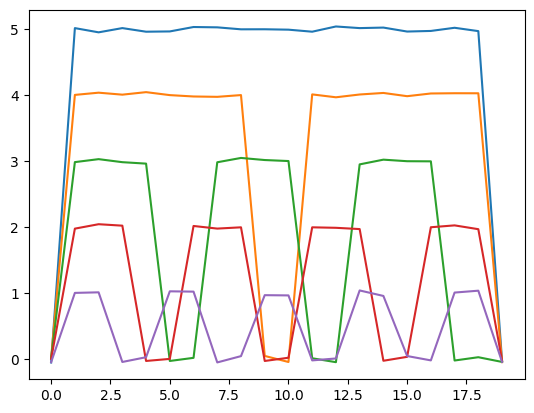

In [10]:
x = np.array([])
y = np.array([])
for f in range(num_features) :
    for i in range(batch_size // num_features) :
        new_feature = generate_feature(base=0, peak=5-f, amount=1+f, rnd=rnd, size=window_length)
        new_targets = np.zeros(num_features)
        new_targets[f] = 1
        x = np.append(x, new_feature)
        y = np.append(y, new_targets)
    plt.plot(new_feature)

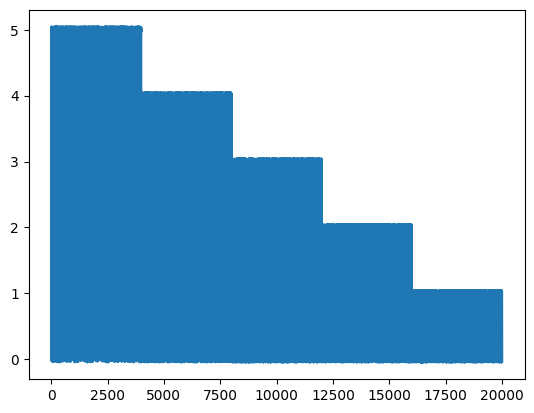

In [11]:
plt.plot(x)

In [13]:
x = x.reshape((batch_size, window_length))
y = y.reshape((batch_size, num_features))

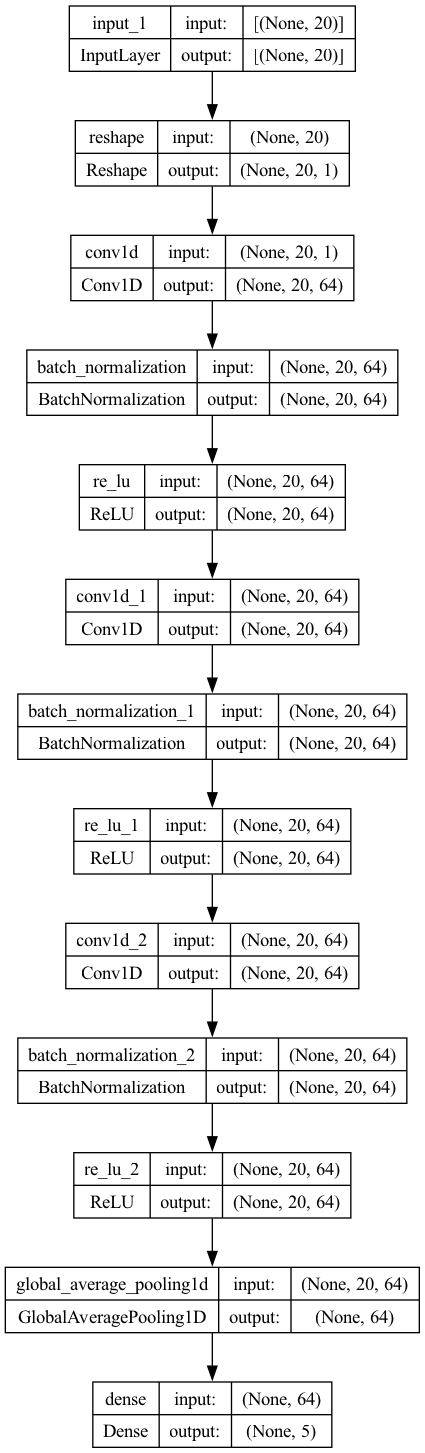

In [18]:
keras.utils.plot_model(model, "my_new_nilm_model.png", show_shapes=True)

In [19]:
# train the model
history = model.fit(
            x=x.reshape(batch_size, window_length),
            y=y.reshape(batch_size, num_features ),
            batch_size=batch_size,
            epochs=epochs)

Epoch 1/500
1/1 [==============================] - 0s 398ms/step - loss: 0.1486 - mse: 0.1486 - msle: 0.0737 - mae: 0.2992
Epoch 2/500
1/1 [==============================] - 0s 29ms/step - loss: 0.1147 - mse: 0.1147 - msle: 0.0553 - mae: 0.2548
Epoch 3/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0924 - mse: 0.0924 - msle: 0.0436 - mae: 0.2252
Epoch 4/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0761 - mse: 0.0761 - msle: 0.0354 - mae: 0.2023
Epoch 5/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0633 - mse: 0.0633 - msle: 0.0292 - mae: 0.1821
Epoch 6/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0531 - mse: 0.0531 - msle: 0.0245 - mae: 0.1650
Epoch 7/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0446 - mse: 0.0446 - msle: 0.0204 - mae: 0.1500
Epoch 8/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0375 - mse: 0.0375 - msle: 0.0171 - mae: 0.1369
Epoch 9/500
1/1 [======

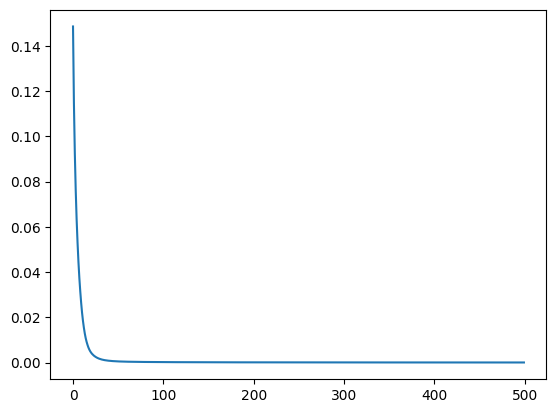

In [20]:
plt.plot(history.history['loss'])

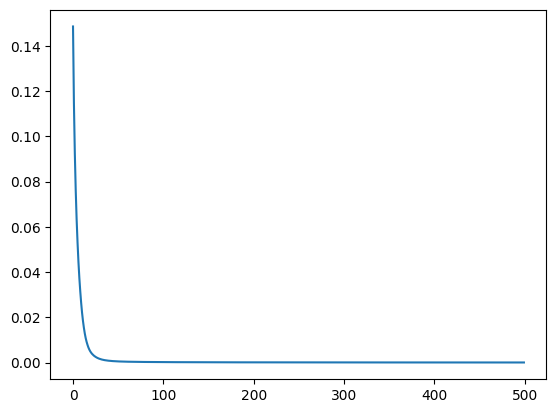

In [21]:
plt.plot(history.history['mse'])

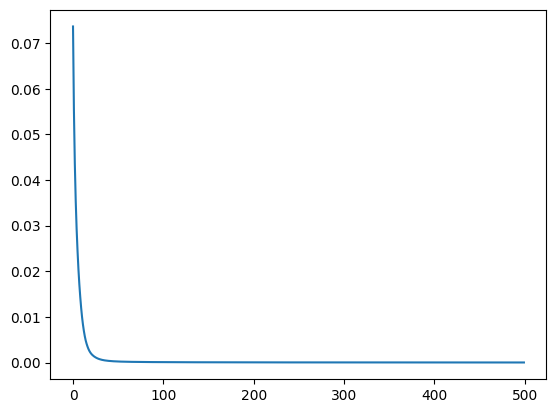

In [22]:
plt.plot(history.history['msle'])

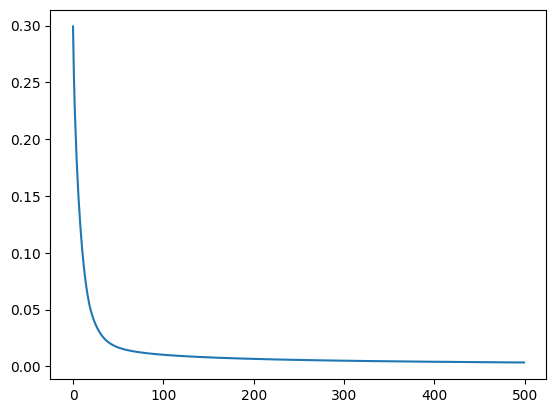

In [23]:
plt.plot(history.history['mae'])

In [24]:
model.save("my_new_nilm_model.keras")

In [25]:
test_x = np.array([])
test_y = np.array([])

for f in range(num_features) :
    for i in range(int(test_batch_size / num_features)) :
        test_x = np.append(test_x, generate_feature(base=0, peak=5-f, amount=1+f, rnd=rnd, size=window_length))
        new_targets = np.zeros(num_features)
        new_targets[f] = 1
        test_y = np.append(test_y, new_targets)
        
test_x = test_x.reshape((test_batch_size, window_length))
test_y = test_y.reshape((test_batch_size, num_features))

In [27]:
# loss='mse', metrics=['mse', 'msle', 'mae']
test1, test2, test3, test4 = model.evaluate(test_x, test_y)

63/63 [==============================] - 0s 2ms/step - loss: 6.0181e-05 - mse: 6.0181e-05 - msle: 2.7111e-05 - mae: 0.0059


In [28]:
predict_x = test_x
predict_x = predict_x.reshape(predict_x.shape[0], window_length)

In [29]:
predict_y = model.predict(predict_x)
print(predict_y)

63/63 [==============================] - 0s 2ms/step
[[9.85628366e-01 1.14057288e-02 5.91591059e-04 1.26245443e-03
  1.11184176e-03]
 [9.86038148e-01 1.10705867e-02 5.70951321e-04 1.23227376e-03
  1.08796428e-03]
 [9.84939754e-01 1.19925635e-02 6.17886428e-04 1.30824652e-03
  1.14145549e-03]
 ...
 [2.39168224e-03 1.87771476e-03 6.80288067e-03 5.34188561e-03
  9.83585835e-01]
 [2.48519378e-03 1.94310711e-03 7.20129302e-03 5.73553750e-03
  9.82634842e-01]
 [2.64530256e-03 2.02647410e-03 7.41872890e-03 6.16296893e-03
  9.81746554e-01]]


In [30]:
predict_y.shape[0]

2000

In [31]:
predict_y

array([[9.85628366e-01, 1.14057288e-02, 5.91591059e-04, 1.26245443e-03,
        1.11184176e-03],
       [9.86038148e-01, 1.10705867e-02, 5.70951321e-04, 1.23227376e-03,
        1.08796428e-03],
       [9.84939754e-01, 1.19925635e-02, 6.17886428e-04, 1.30824652e-03,
        1.14145549e-03],
       ...,
       [2.39168224e-03, 1.87771476e-03, 6.80288067e-03, 5.34188561e-03,
        9.83585835e-01],
       [2.48519378e-03, 1.94310711e-03, 7.20129302e-03, 5.73553750e-03,
        9.82634842e-01],
       [2.64530256e-03, 2.02647410e-03, 7.41872890e-03, 6.16296893e-03,
        9.81746554e-01]], dtype=float32)

In [32]:
cnt_wrong = 0
cnt_correct = 0

for i in range(predict_y.shape[0]) :
    predicted_pos = np.argmax(predict_y[i])
    trained_pos =  np.argmax(test_y[i])
    if predicted_pos != trained_pos :
        cnt_wrong = cnt_wrong + 1
        #print("predicted feature: ", predicted_pos, " and trained feature: ", trained_pos)
        print("predicted: ", predict_y[i], " and trained: ", test_y[i])
        plt.plot(predict_x[i])
    else :
        cnt_correct = cnt_correct + 1

In [33]:
print("predictions... ")
print(" total:   ", cnt_wrong + cnt_correct)
print(" correct: ", cnt_correct)
print(" wrong:   ", cnt_wrong)

predictions... 
 total:    2000
 correct:  2000
 wrong:    0
